<a href="https://colab.research.google.com/github/darja/AndroidProductFlavors/blob/master/13_classic_ml_2_pro_ryazhskikh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Классическое машинное обучение: признаки для разных типов данных

* Сделать классификатор открытый - закрытый глаз с помощью признаков для изображения. 
* Для зарузки файлов eyes_test.npz и eyes_train.npz использовать копию ноутбука dz_ml2_eyes.ipynb 
* [База](https://www.dropbox.com/s/bm1u6lkx6owy2fk/eyes.zip?dl=0)
* [Ноутбук](https://colab.research.google.com/drive/1AVbY3qihYa79B4O_jSg8xRBMjWhP6T43)
* В качестве признаков рекомендуется использовать одновременно HoG и LBP.
* Сам алгоритм может быть такой же, как в предыдущем домашнем задании для классического машинного обучения про классификатор лицо-не лицо. Только вместо интенсивностей используются признаки. Для одновременного использования признаков HoG и LBP можно сделать отдельно методы главных компонент для каждого типа признаков, сконкатенировать преобразованные признаки в один вектор и затем запускать классификатор, например SVM.
* В отчет - описание построенного классификатора и ошибки первого и второго рода, accuracy.
* Опционально - прогнать полученный алгоритм на базе лицо-не лицо
* Опционально - обучить сверточную сеть классифицировать открытый - закрытый глаз, лицо - не лицо.

# Подготовка окружения

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.feature import hog, local_binary_pattern
from skimage import data, color, exposure

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn import metrics

## Чтение базы

### Подключение Google Drive

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

### Распаковка базы

In [2]:
!cp /content/gdrive/'My Drive'/neural/eyes.zip eyes.zip
!unzip eyes.zip

Archive:  eyes.zip
  inflating: eyes_test.npz           
  inflating: eyes_train.npz          


### Чтение файлов

In [0]:
data = np.load('eyes_train.npz')
train_images = data["images"]
train_labels = data["labels"]

data = np.load('eyes_test.npz')
test_images = data["images"]
test_labels = data["labels"]

In [4]:
print("Train set: %s, labels: %s" % (train_images.shape, train_labels.shape))
print("Train labels: %s open, %s closed" % (sum(train_labels==1), sum(train_labels==0)))
print("\nTest set: %s, labels: %s" % (test_images.shape, test_labels.shape))
print("Test labels: %s open, %s closed" % (sum(test_labels==1), sum(test_labels==0)))


Train set: (3200, 24, 24), labels: (3200,)
Train labels: 1629 open, 1571 closed

Test set: (800, 24, 24), labels: (800,)
Test labels: 409 open, 391 closed


# Подготовка данных для классификатора

## Подготовка HOG-дескрипторов

### Чтение HoG-дескрипторов

In [5]:
to_hog = lambda image: hog(image, orientations=8, pixels_per_cell=(3, 3), cells_per_block=(1, 1), block_norm="L1", visualize=False)

# Train set
train_hog_raw = []
for img in train_images:
    train_hog_raw.append(to_hog(img))
train_hog_raw = np.array(train_hog_raw)
print("Train set hog descriptors: ", train_hog_raw.shape)

test_hog_raw = []
for img in test_images:
    test_hog_raw.append(to_hog(img))
test_hog_raw = np.array(test_hog_raw)
print("Test set hog descriptors: ", test_hog_raw.shape)


Train set hog descriptors:  (3200, 512)
Test set hog descriptors:  (800, 512)


#### Что не так с этим np.vectorize?

In [0]:
# почему не работает через vectorize?
hog_vec = np.vectorize(lambda image: hog(image, orientations=8, pixels_per_cell=(3, 3), cells_per_block=(1, 1), block_norm="L1", visualize=False), otypes=[np.ndarray])

train_images_hog = hog_vec(train_images)
test_images_hog = hog_vec(test_images)

### Нормализация

In [7]:
hog_mean = train_hog_raw.mean(0)
hog_std = train_hog_raw.std(0)
train_hog = np.zeros_like(train_hog_raw)
for i in range(0, train_hog_raw.shape[0]):
    train_hog[i,:]= (train_hog_raw[i,:] - hog_mean) / hog_std
print("Normalized hog descriptors: ", train_hog.shape)


Train set hog descriptors:  (3200, 512)


### Выделение главных компонентов

512
Original train set: (3200, 512)
Transformed train set: (3200, 450)


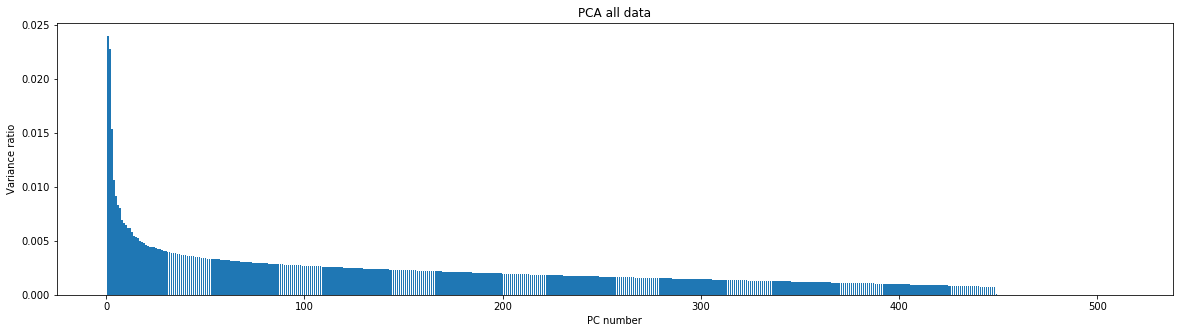

In [16]:
flen = train_hog.shape[1]
print(flen)

pca = PCA(n_components=flen)
pca.fit(train_hog)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1,flen+1), pca.explained_variance_ratio_)
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")

pca = PCA(n_components=450)
pca.fit(train_hog)

#преобразуем обучающую выборку
print("Original train set:", train_hog.shape)
train_hog_pca = pca.transform(train_hog)
print("Transformed train set:", train_hog_pca.shape)

### Преобразование тестового набора

In [17]:
test_hog = np.zeros_like(test_hog_raw)
for i in range(0, test_hog_raw.shape[0]):
    test_hog[i,:]= (test_hog_raw[i,:] - hog_mean) / hog_std
print(test_hog.shape)

print("Original test set:", test_hog.shape)
test_hog_pca = pca.transform(test_hog)
print("Transformed test set:", test_hog_pca.shape)

(512,)
(800, 512)
(800, 512)
Original test set: (800, 512)
Transformed test set: (800, 450)


## Подготовка LBP

### Чтение LBP

In [19]:
radius = 3
n_points = 8 * radius

lbp = lambda image: local_binary_pattern(image, n_points, radius)

# Train set
train_lbp_raw = []
for img in train_images:
    train_lbp_raw.append(lbp(img).ravel())
train_lbp_raw = np.array(train_lbp_raw)
print("Train set lbp: ", train_lbp_raw.shape)

test_lbp_raw = []
for img in test_images:
    test_lbp_raw.append(lbp(img).ravel())
test_lbp_raw = np.array(test_lbp_raw)
print("Test set lbp: ", test_lbp_raw.shape)


Train set lbp:  (3200, 576)
Test set lbp:  (800, 576)


### Нормализация

In [20]:
lbp_mean = train_lbp_raw.mean(0)
lbp_std = train_lbp_raw.std(0)
train_lbp = np.zeros_like(train_lbp_raw)
for i in range(0,train_lbp_raw.shape[0]):
    train_lbp[i,:]= (train_lbp_raw[i,:] - lbp_mean) / lbp_std

(576,)


### Выделение главных компонентов

576
Transformed train set: (3200, 200)


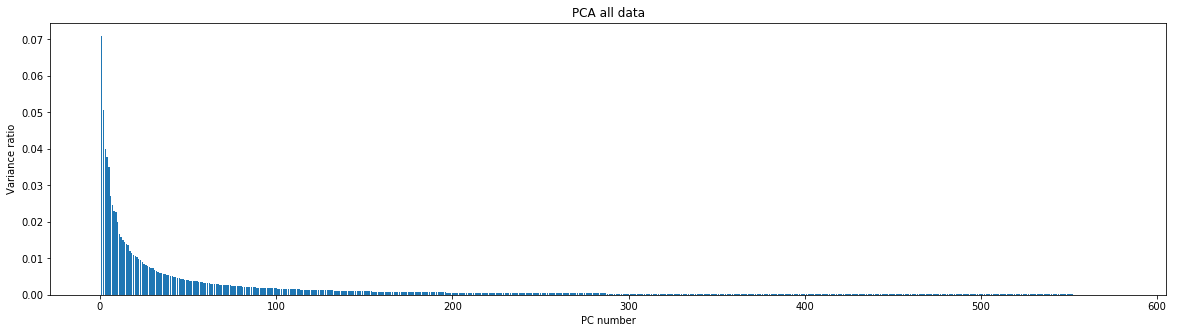

In [22]:
flen = train_lbp.shape[1]

pca = PCA(n_components=flen)
pca.fit(train_lbp)

plt.figure(figsize=(20, 5))
plt.bar(np.arange(1, flen+1), pca.explained_variance_ratio_)
plt.ylabel("Variance ratio")
plt.xlabel("PC number")
plt.title("PCA all data")

pca = PCA(n_components=200)
pca.fit(train_lbp)

#преобразуем обучающую выборку
train_lbp_pca = pca.transform(train_lbp)
print("Transformed train set:", train_lbp_pca.shape)

#### Преобразование тестового набора

In [26]:
test_lbp = np.zeros_like(test_lbp_raw)
for i in range(0, test_lbp_raw.shape[0]):
    test_lbp[i,:]= (test_lbp_raw[i,:] - lbp_mean) / lbp_std

print("Original test set:", test_lbp.shape)
test_lbp_pca = pca.transform(test_lbp)
print("Transformed test set:", test_lbp_pca.shape)

Original test set: (800, 576)
Transformed test set: (800, 200)


## Объединение HoG- и LBP-компонентов

In [31]:
def union_features(im_hog, im_lbp):
    train_set = []
    for i in range(0, im_hog.shape[0]):
        train_set.append(np.append(im_hog[i], im_lbp[i]))
    train_set = np.array(train_set)
    return train_set
    

train_combined_pca = union_features(train_hog_pca, train_lbp_pca)
print("Train data\n\tHoG: %s\n\tLBP: %s\n\tCombined: %s" % (train_hog_pca.shape, train_lbp_pca.shape, train_combined_pca.shape))

test_combined_pca = union_features(test_hog_pca, test_lbp_pca)
print("\n\nTrain data\n\tHoG: %s\n\tLBP: %s\n\tCombined: %s" % (test_hog_pca.shape, test_lbp_pca.shape, test_combined_pca.shape))


Train data
	HoG: (3200, 450)
	LBP: (3200, 200)
	Combined: (3200, 650)


Train data
	HoG: (800, 450)
	LBP: (800, 200)
	Combined: (800, 650)


# Классификация

## Утилиты

In [0]:
#вычисление ошибок первого и второго рода
def calculate_errors(expected, predicted):    
    acc = metrics.accuracy_score(expected, predicted)
    FP = sum((expected == 0) & (predicted == 1))
    FN = sum((expected == 1) & (predicted == 0))
    TP = sum((expected == 1) & (predicted == 1))
    TN = sum((expected == 0) & (predicted == 0))
    FPR = FP / (FP + TN)
    FNR = FN / (TP + FN)
    return (FPR, FNR, acc)

def print_errors(expected, predicted):    
    FPR, FNR, acc = calculate_errors(expected, predicted)
    print("Accuracy:", acc)
    print('ERR1 ', FPR)
    print('ERR2 ', FNR)
    return (FPR, FNR, acc)

def fit_and_predict(classifier, train_set, test_set):
    classifier.fit(train_set, train_labels)

    predicted = classifier.predict(test_set)
    print_errors(test_labels, predicted)
    
def fit_and_predict_all_datasets(create_classifier):
    print("HoG classification")
    fit_and_predict(create_classifier(), train_hog, test_hog)

    print("\n\nHoG PCA classification")
    fit_and_predict(create_classifier(), train_hog_pca, test_hog_pca)

    print("\n\nLBP classification")
    fit_and_predict(create_classifier(), train_lbp, test_lbp)

    print("\n\nLBP PCA classification")
    fit_and_predict(create_classifier(), train_lbp_pca, test_lbp_pca)
    
    print("\n\nCombined HoG + LBP PCA classification")
    fit_and_predict(create_classifier(), train_combined_pca, test_combined_pca)

## Классификация с помощью SVC

In [33]:
fit_and_predict_all_datasets(lambda: SVC(gamma="auto"))

HoG classification
Accuracy: 0.93375
ERR1  0.056265984654731455
ERR2  0.07579462102689487


HoG PCA classification
Accuracy: 0.93375
ERR1  0.056265984654731455
ERR2  0.07579462102689487


LBP classification
Accuracy: 0.94125
ERR1  0.058823529411764705
ERR2  0.05867970660146699


LBP PCA classification
Accuracy: 0.9425
ERR1  0.061381074168797956
ERR2  0.05378973105134474


Combined HoG + LBP PCA classification
Accuracy: 0.96
ERR1  0.028132992327365727
ERR2  0.05134474327628362
